## Sztuczne sieci neuronowe - laboratorium 7

### Splotowe sieci neuronowe

Na poprzednich zajęciach wytrenowaliśmy gęstą sieć neuronową w zagadnieniu klasyfikacji binarnej obrazu - do rozróżniania ptaków i samolotów.

Niestety nasza sieć nie poradziła sobie z tym zadaniem najlepiej - doszło do przeuczenia modelu. Jest to związane z faktem, iż sieci gęste nie nadają się do przetwarzania danych obrazkowych, np. położenie piksela na obrazku nie ma dla nich znaczenia.

Dziś (i za tydzień) zajmiemy się **splotowymi sieciami neuronowymi** (ang. CNN - convolutional neural networks) w tym samym zagadnieniu.

### Z poprzednich ćwiczeń

Uruchom kolejne komórki, wykorzystujące kod z poprzednich zajęć, aby przygotować zbiór danych - `cifar2`.

In [1]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
class_names = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

In [3]:
tensor_cifar10 = datasets.CIFAR10("data", train=True, download=False, transform=transforms.ToTensor())
tensor_cifar10_val = datasets.CIFAR10("data", train=False, download=False, transform=transforms.ToTensor())

In [4]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
per_channel_means = imgs.view(3, -1).mean(dim=1)
per_channel_std = imgs.view(3, -1).std(dim=1)

In [5]:
transforms_compose = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(per_channel_means, per_channel_std)
])

transformed_cifar10 = datasets.CIFAR10("data", train=True, download=False, transform=transforms_compose)
transformed_cifar10_val = datasets.CIFAR10("data", train=False, download=False, transform=transforms_compose)

In [6]:
label_map = {0: 0, 2: 1}
new_class_names  = [class_names[i] for i in label_map]

cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in label_map]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in label_map]

### Warstwa splotowa - Conv2d

Podstawowym komponentem splotowych sieci neuronowych jest warstwa splotowa. W przetwarzaniu obrazów powszechnie stosuje się warstwę `nn.Conv2d`, która przyjmuje następujące argumenty (w wersji minumum):
- `in_channels` - liczba kanałów wejściowych (cech)
- `out_channels` - liczba kanałów wyjściowych (równa liczbie filtrów)
- `kernel_size` - wymiary pojedynczego filtra - podawany jako para liczb lub pojedyncza liczba (dla filtrów kwadratowych - zazwyczaj takich będziemy używać)

Domyślnie warstwa `Conv2d` dodaje do wyjścia z każdego filtra wyraz wolny (jest to także trenowalny parametr).

Inne atrybuty warstwy splotowej to m.in.:
- `padding` - liczba pikseli "padowanych" do poszczególnych wymiarów obrazka przed przejściem przez warstwę splotową
- `stride` - krok / przeskok (w pikselach) filtra aplikowanego do wejścia (domyślnie 1 - co każdy piksel)

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

#### Ćwiczenie

Stwórz warstwę `Conv2d`, która obsłuży obrazki RGB używając 16 kwadratowych filtrów rozmiaru 3x3. Przypisz ją do zmiennej `conv`.
Ile parametrów ma tak stworzona warstwa? Sprawdź zawartość `conv.weight.shape` i `conv.bias.shape`.

In [7]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv.weight.shape

torch.Size([16, 3, 3, 3])

In [8]:
conv.bias.shape

torch.Size([16])

#### Ćwiczenie
Przepuść wybrany obrazek (wybrany indeks, np. 2) ze zbioru `cifar2` przez stworzoną warstwę `conv`.  
Pamiętaj o zastosowaniu funkcji `unsqueeze()` przy puszczaniu przez warstwę pojedynczego obrazka. Sprawdź rozmiar (`.shape`) tensora przed przejściem przez warstwę i na jej wyjściu.

In [11]:
img, _ = cifar2[2]
len(img)

3

In [12]:
conv(img.unsqueeze(0)).shape

torch.Size([1, 16, 30, 30])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5775881..1.7572223].


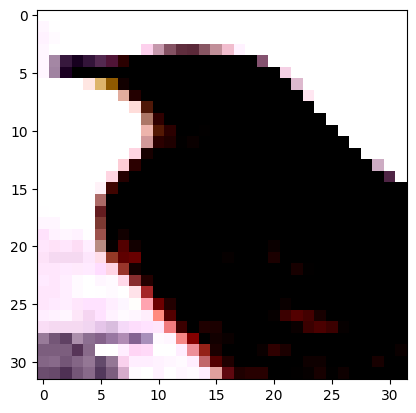

In [13]:
plt.imshow(img.permute(1, 2, 0))
plt.show()

#### Ćwiczenie
Stwórz warstwę `conv` jeszcze raz, tym razem podając `padding=1`, i znów przepuść przez nią obrazek. Jak zmieni się rozmiar wyjścia?

In [14]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
conv.weight.shape

torch.Size([16, 3, 3, 3])

In [15]:
conv(img.unsqueeze(0)).shape

torch.Size([1, 16, 32, 32])

### Filtry pozwalają wykrywać cechy obrazów

Wartości filtrów (i wyrazy wolne) w danej warstwie splotowej znajdowane są podczas uczenia sieci neuronowej - są to parametry modelu.

Po wyuczeniu, poszczególne filtry umieją "zwracać uwagę" np. na określone kształty, krawędzie, kolory itd (aktywować się, tj. zwracać wysokie wartości na wyjściu - przy takich wejściach).

Na razie spróbujmy sami wymusić wartości parametrów warstwy `conv`, uzyskując w kolejnych ćwiczeniach:
- warstwę złożoną z jednakowych filtrów 3x3 przetwarzających każdy piksel w średnią jego sąsiadów
- warstwę złożoną z jednakowych filtrów 3x3, w których kolejne kolumny zawierają po 3 wartości -1, 0 i 1

Sprawdzimy, jak będzie wyglądał wejściowy obrazek po przepuszczeniu przez tak "z palca" stworzone warstwy.

#### Ćwiczenie

Uzupełnij brakującą wartość w nawiasie, aby stworzyć filtry uśredniające sąsiednie piksele. Jaką należy wpisać wartość?

hint: Filtry mają rozmiar 3x3.

In [21]:
with torch.no_grad():
    conv.weight.fill_(1/9)
    conv.bias.zero_()

#### Ćwiczenie
Co stanie się z obrazkiem po przepuszczeniu przez taką warstwę? Dlaczego? Uruchom poniższą komórkę, aby się przekonać

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5775881..1.7572223].


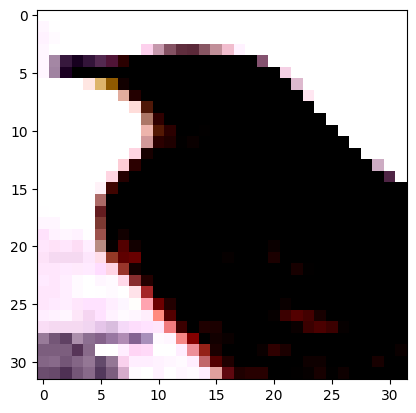

In [22]:
plt.imshow(img.permute(1, 2, 0))

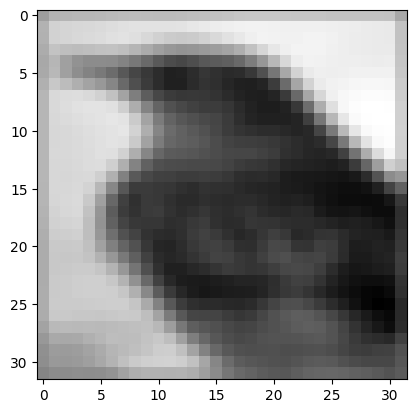

In [23]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

#### Ćwiczenie

Niech teraz warstwa składa się z filtrów 3x3 z kolumnami kolejno o wartościach -1, 0, 1. Na jakie wejścia będą reagowały takie filtry? Dlaczego? Uruchom poniższą komórkę, aby się przekonać. Co by się stało w przypadku -1, 0, 1 w wierszach zamiast w kolumnach?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5775881..1.7572223].


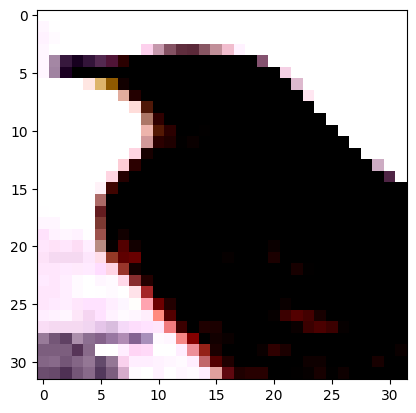

In [24]:
plt.imshow(img.permute(1, 2, 0))

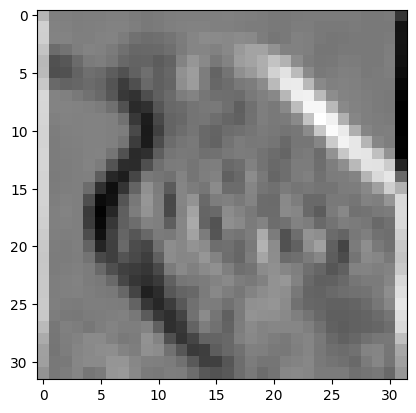

In [25]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

output = conv(cifar2[2][0].unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

### Pooling - redukcja rozmiarów

Nie wszystkie "cechy" oryginalnego obrazka można wyłapać małymi filtrami (np. różna skala obrazków). Dlatego stosuje się sekwencje kolejnych filtrów oraz "downsampling", czyli stopniowe zmniejszanie wymiarów reprezentacji wejściowych danych. W ten sposób filtry aplikoawne do pomniejszonej reprezentacji "patrzą" na większe fragmenty oryginalnego obrazka (ang. receptive field).

Najpopularniejszym wariantem downsamplingu jest tzw. "max pooling", realizowany w PyTorch przez `torch.nn.MaxPool2d`.

Max pooling "pozostawia" największą wartość należącą do danego "okna", np. w przypadku poolingu 2x2 (popularny wariant) "kompresujemy" cztery piksele do jednego o wartości największej spośród tych czterech, pomniejszając wejściowy tensor dwukrotnie.

Max pooling działa bazując na założeniu, że skoro warstwa splotowa aktywuje się dla pewnych cech, to ta aktywacja (a więc i dana cecha) "przetrwa" przejście przez tak zdefiniowany downsampling (największa wartość zostanie zachowana).

Warstwy typu pooling nie mają trenowalnych parametrów.

https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

In [29]:
conv = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.MaxPool2d(2, 2)
)

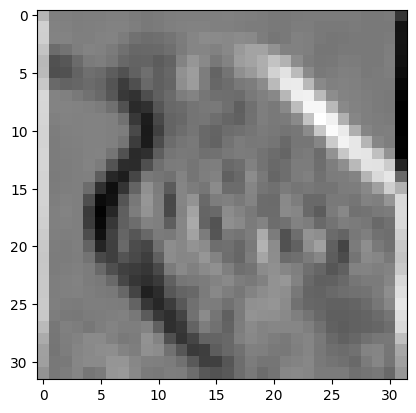

In [30]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

### Sieć splotowa

W podstawowym wariancie sieć splotowa składa się z sekwencji warstw splotowych (wraz z funkcjami aktywacji) oraz warstw typu pooling. Na samym końcu, gdy reprezentacja "2D" jest już odpowiednio mała, typowo "wypłaszcza" się ją i dokłada się warstwy gęste np. na potrzeby zadania klasyfikacji.

Filtry początkowych warstw splotowych operują na lokalnych sąsiedztwach pikseli, ale już kolejne warstwy splotowe - dzięki zastosowaniu downsamplingu (poolingu) "patrzą" na większe grupy pikseli (ang. receptive field).

Na poprzednich zajęciach definiowaliśmy sieć neuronową używając tzw. sekwencyjnego API (z użyciem `nn.Sequential`). Jest ono użyteczne przy prostych modelach, ale dość mocno ograniczone (m.in. patrz: rozdział 8.2.4 w książce).

Innym sposobem definiowania sieci neuronowej jest implementacja jej jako klasy dziedziczącej po `torch.nn.Module` (wspomniane na lab. 4 i w rozdziale 6.).

Dziedziczenie po `nn.Module` w wariancie minimum wymaga zdefiniowania metody `forward()`, która określa sekwencję warstw aplikowanych do danych wejściowych przy kroku "w przód" (krok `backward()` będzie za nas wykonywał `autograd`).

Sieć zdefiniowana w ten sposób może mieć także "podmoduły", definiowane jako atrybuty klasy w konstruktorze. Podmoduły te, reprezentujące poszczególne warstwy (lub grupy warstw) - także dziedziczące po`nn.Module` - będą przechowywały wartości swoich parametrów (patrz: rozdział 8.3.2).

#### Ćwiczenie
Zdefiniuj sieć splotową tworząc klasę `Net`. Niech posiada warstwy (podane jako atrybuty klasy `Net` w konstruktorze):
- `conv1` - 3 kanały wejściowe, 16 filtrów 3x3, padding=1
- `conv2` - 16 kanałów wejściowych, 8 filtrów 3x3, padding=1
- po obu tych warstwach: funkcje aktywacji tangens hiperboliczny (`act1` i `act2`)
- po funkcjach aktywacji: warstwy typu max pooling 2x2 (`pool1`, `pool2`)
- na końcu "sieć gęstą" złożoną z dwóch warstw `nn.Linear` (`fc1`, `fc2`) rozdzielonych  funkcją aktywacji (`act3`)

Zastąp wszystkie wystąpienia `None` kodem.


Zastanów się, jaki musi być rozmiar wejścia do "sieci gęstej" i rozmiar wyjścia z niej. Przyjmij "pośredni" rozmiar w sieci gęstej (wyjście z pierwszej warstwy `Linear` i wejście do drugiej) równy 32.

Następnie zdefiniuj, jak dane wejściowe (argument `x`) mają być przetwarzane przez sieć w kroku "w przód", tj. uzupełnij implementację metody `self.forward()`.

In [39]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # uzupełnij zgodnie z opisem powyżej dla conv1, a potem dopisz kolejne podmoduły (warstwy)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # zaimplementuj logikę kroku "w przód", dla wygody w kilku liniach
        out = self.conv1(x)
        out = self.act1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.act2(out)
        out = self.pool2(out)
        out = out.view(out.size(0), -1)  # spłaszczanie
        out = self.fc1(out)
        out = self.act3(out)
        out = self.fc2(out)
        return out



#### Ćwiczenie
Zainicjalizuj model używając zdefiniowanej właśnie klasy `Net`. Przepuść przez model obrazek.

Wywołanie `model(dane)` jest równe wywołaniu `model.forward(dane)`.

In [40]:
model = Net()
model(cifar2[2][0].unsqueeze(0))

tensor([[-0.0597, -0.0957]], grad_fn=<AddmmBackward0>)

#### Ćwiczenie (opcjonalne)
Funkcje aktywacji i warstwy typu pooling nie mają trenowalnych parametrów. W związku z tym nie ma potrzeby rejestrowania ich jako podmodułów klasy `Net`. Zamiast tego, móżemy wykorzystać ich odpowiedniki z tzw. funkcjonalnego API, zrealizowanego jako funkcje w module `torch.nn.functional` i użyć ich wewnątrz metody `forward()`.

In [41]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # uzupełnij zgodnie z opisem powyżej dla conv1, a potem dopisz kolejne podmoduły (warstwy)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.functional.tanh(self.conv1)
        self.pool1 = nn.functional.max_pool2d(self.conv1, 2, 2)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.act2 = nn.functional.tanh(self.conv2)
        self.pool2 = nn.functional.max_pool2d(self.conv2, 2, 2)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # zaimplementuj logikę kroku "w przód", dla wygody w kilku liniach
        out = self.conv1(x)
        out = self.act1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.act2(out)
        out = self.pool2(out)
        out = out.view(out.size(0), -1)  # spłaszczanie
        out = self.fc1(out)
        out = self.act3(out)
        out = self.fc2(out)
        return out



### Podsumowanie

Na dzisiejszym laboratorium:
- poznaliśmy działanie warstwy splotowej: `Conv2d`
- poznaliśmy działanie warstwy pooling na przykładzie `MaxPool2d`
- zdefiniowaliśmy splotową sieć neuronową poprzez dziedziczenie po klasie `nn.Module`.

Na kolejnych zajęciach wytrenujemy sieć splotową bazując na zdefiniowanym powyżej modelu, a także rozszerzając go o dodatkowe komponenty stosowane w praktyce w celu zapewnienia regularyzacji modelu i stabilności treningu.

### Wnioski
Warstwy pooling usprawniają uczenie sieci neuronowej, zmniejszając liczbę parametrów i obciążenie obliczeniowe.